In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

import time

color_pal = sns.color_palette()

## Read in data and engineer features

In [74]:
#read X data
df_input = pd.read_csv('data/Germany/input_data.csv')
df_input = df_input.set_index('time')
df_input.index = pd.to_datetime(df_input.index)

In [75]:
#create lag features (average over the past 15, 30 and 90 days)

for j in ['rr','tg','tn','tx','pp','hu','fg','qq','et']:
    temps = pd.DataFrame(df_input[j].values)
    shifted = temps.shift(1)
    for k in [15,30,90]:
        window, means, mins, maxs = {}, {}, {}, {}
        window["{}".format(k)] = shifted.rolling(window=k)
        means["{}".format(k)] = window["{}".format(k)].mean()
        df_input["{}_avg_{}".format(j,k)]=means["{}".format(k)].to_numpy()
    

# drop missing values after creating lag features
df_input.dropna(inplace = True)
print(df_input.shape)
df_input.head()

(11598, 36)


,rr,tg,tn,tx,pp,hu,fg,qq,et,rr_avg_15,...,hu_avg_90,fg_avg_15,fg_avg_30,fg_avg_90,qq_avg_15,qq_avg_30,qq_avg_90,et_avg_15,et_avg_30,et_avg_90
time,,,,,,,,,,,,,,,,,,,,,
1990-04-01,0.0,8.91,0.11,17.890000,1024.20010,74.135,1.69,231.0,2.778187,0.653333,...,80.076294,2.267333,2.742,2.857000,138.000000,127.766667,81.300000,1.582920,1.430509,0.855079
1990-04-02,0.0,9.67,1.28,18.330000,1010.00000,71.015,1.01,212.0,2.621987,0.653333,...,79.876127,2.250667,2.650,2.864333,140.866667,132.466667,83.533333,1.626284,1.496387,0.883505
1990-04-03,1.3,7.96,4.34,16.449999,1002.50000,69.805,3.31,131.0,1.547984,0.653333,...,79.649905,2.239333,2.541,2.864556,141.933333,137.033333,85.522222,1.652356,1.561169,0.909737
1990-04-04,0.0,3.95,0.04,8.320000,1015.10004,67.650,2.93,172.0,1.775852,0.740000,...,79.467961,2.398667,2.529,2.878111,137.866667,137.700000,86.811111,1.603935,1.577202,0.925521
1990-04-05,4.0,3.30,0.49,6.120000,1017.90000,87.670,1.69,81.0,0.816236,0.740000,...,79.235350,2.370667,2.530,2.886000,144.933333,139.033333,88.388889,1.670174,1.593300,0.942652


In [81]:
# extract X from training period
df_X = df_input[(df_input.index>='2002-05-01' )& (df_input.index<='2016-12-31')]

In [84]:
#read y data
df_y = pd.read_csv('data/Germany/heads.csv')
df_y = df_y.set_index('Date')
df_y.index = pd.to_datetime(df_y.index)
df_y.index = df_y.index.rename("time")
df_y = df_y[(df_y.index>=df_X.index[0])]
print(df_y.shape)
df_y.head()

(5359, 1)


,head
time,
2002-05-01,374.76
2002-05-02,374.75
2002-05-03,374.74
2002-05-04,374.72
2002-05-05,374.71


In [85]:
# get rid of outliers
for i in df_X.columns:
    std = np.std(df_X[i],ddof=1)
    mean = np.mean(df_X[i])
    index = (df_X[(df_X[i]>3*std+mean) | (df_X[i]<mean-3*std)]).index
    df_X.drop(index=index,inplace=True)
    df_y.drop(index=index,inplace=True)

print(df_X.shape)
print(df_y.shape)

/var/folders/3h/rwm3946s6m393kd1m_w94xl00000gn/T/ipykernel_53344/3185498811.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X.drop(index=index,inplace=True)


(4808, 36)
(4808, 1)


In [108]:
# add 'day' feature
def create_features(df):
    #df['year'] = df.index.year
    #df['month'] = df.index.month
    df['day'] = df.index.day
    #df['dayofweek'] = df.index.day_of_week
    #df['quarter'] = df.index.quarter
    return(df)

In [109]:
df_X = create_features(df_X)

/var/folders/3h/rwm3946s6m393kd1m_w94xl00000gn/T/ipykernel_53344/1610939616.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day


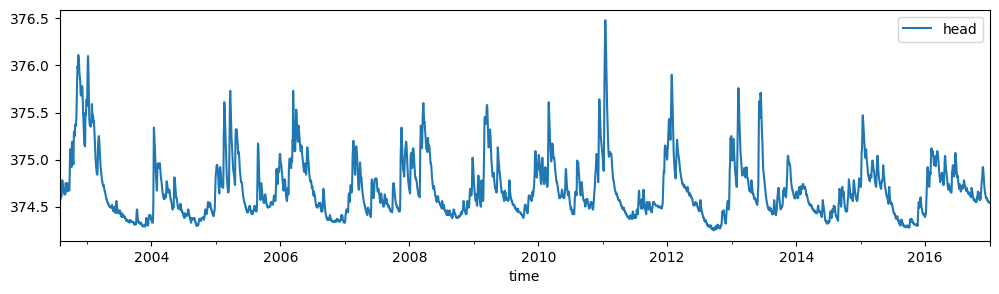

In [27]:
# visualize heads data
df_y.plot(figsize=(12,3))
plt.show()

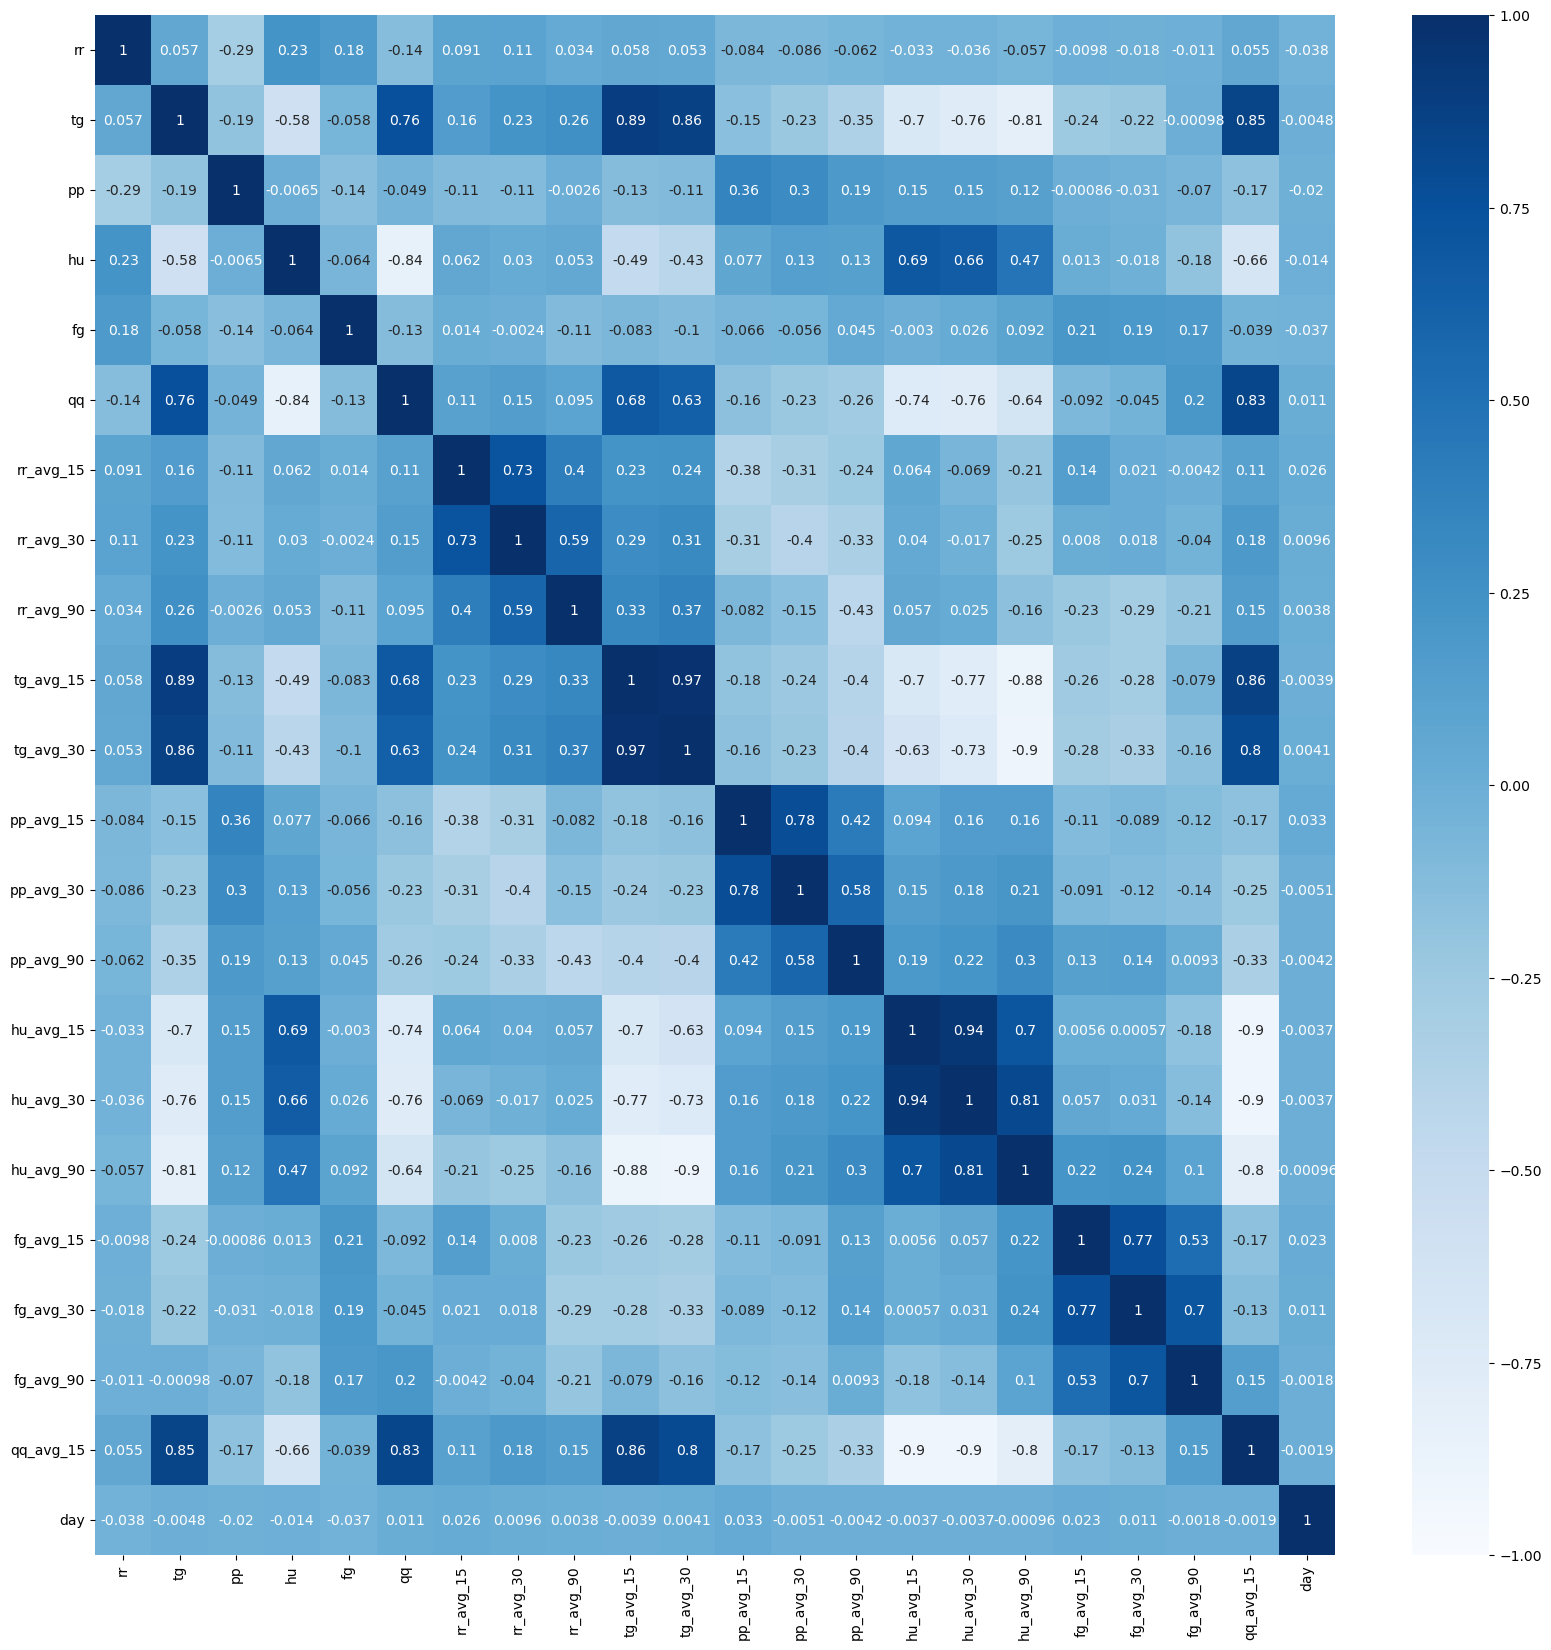

In [144]:
# check for multicolinearity
corr_matrix = df_X.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, cmap='Blues',vmin=-1,vmax=1, annot=True) 
plt.show()

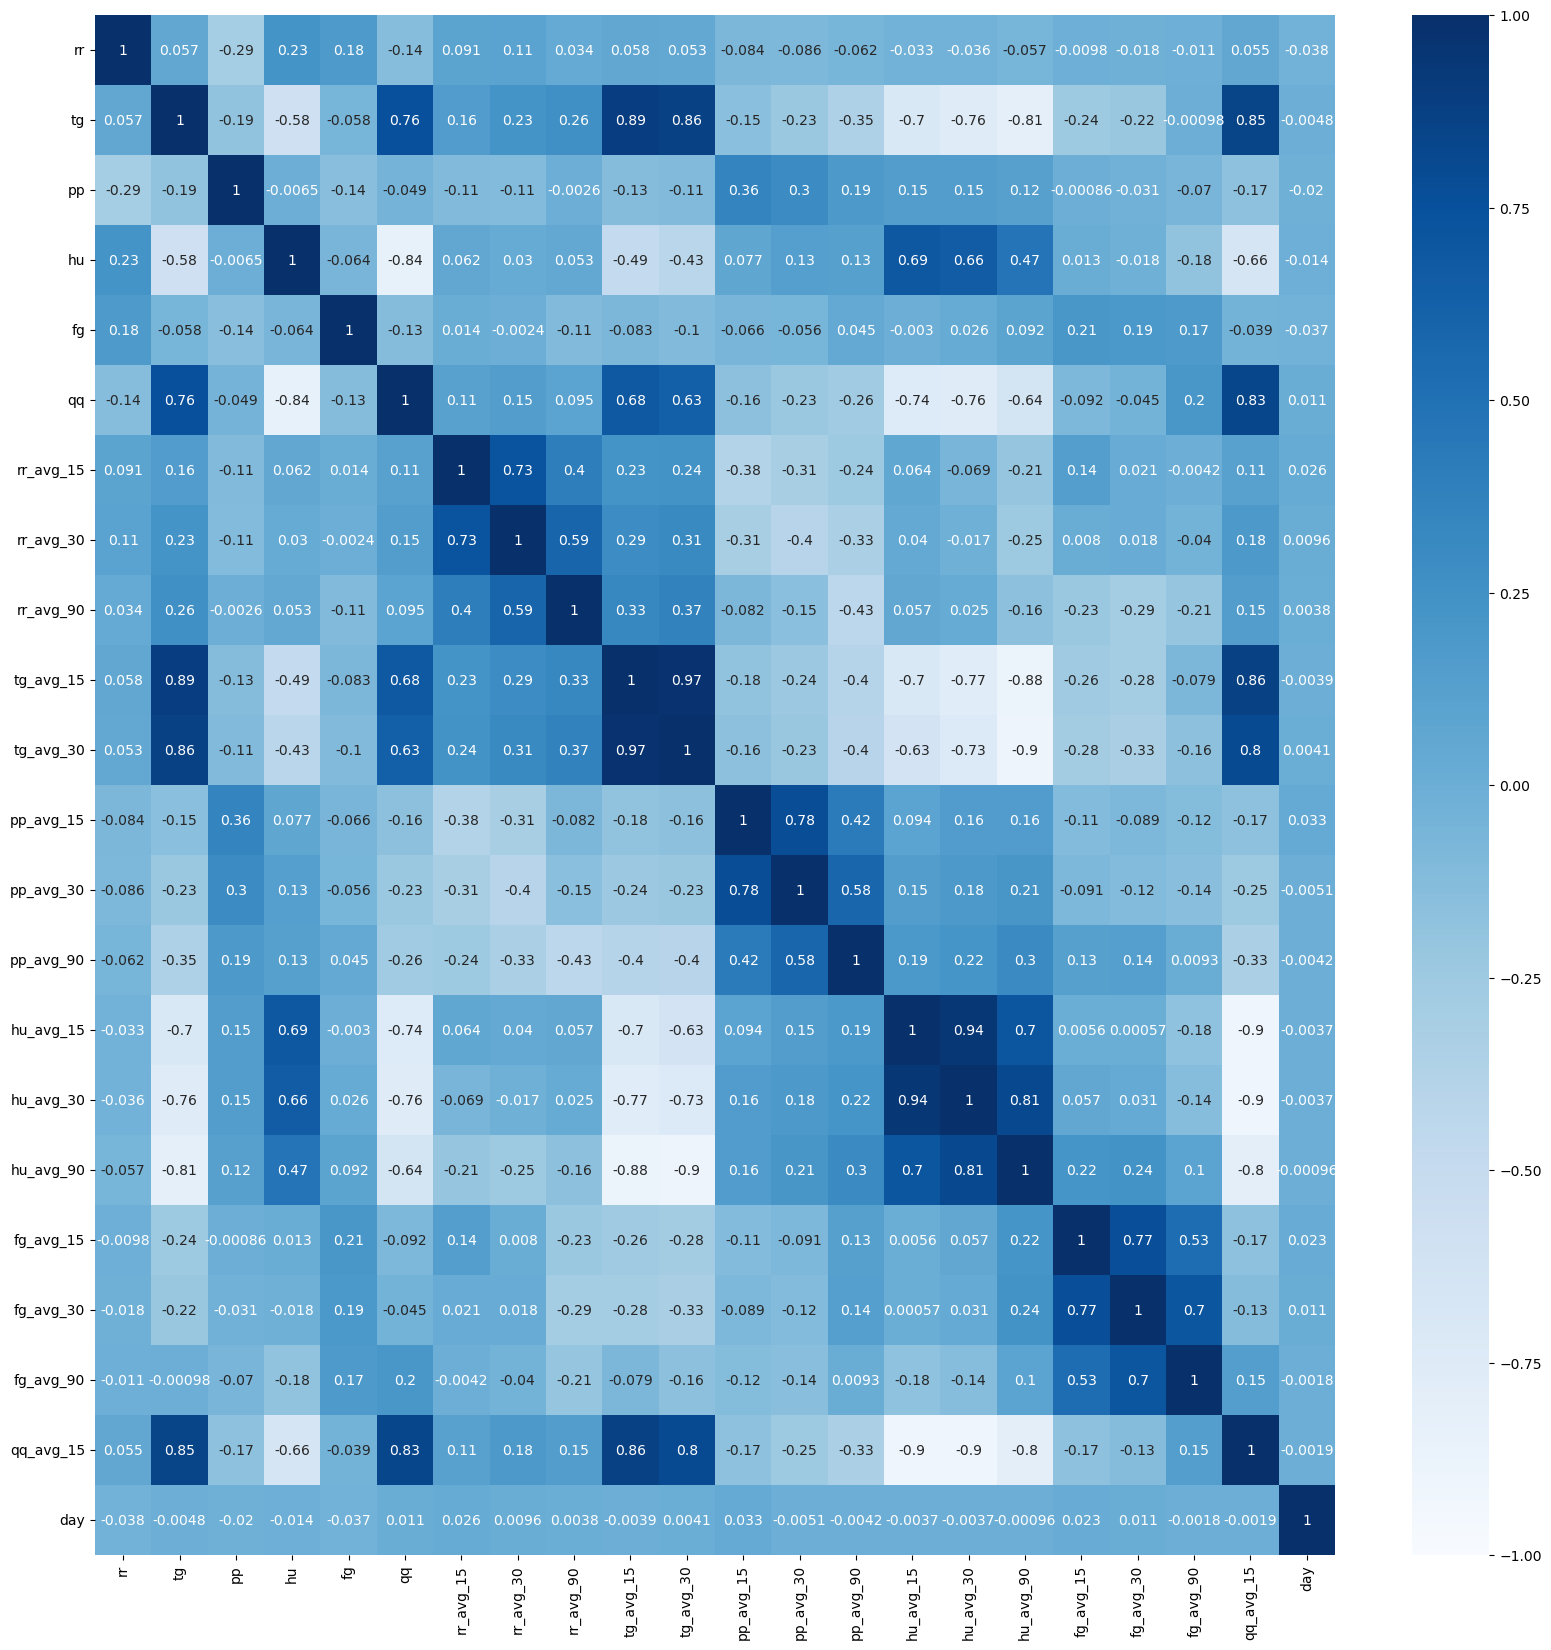

In [110]:
df_X = df_X.drop(columns=[col for col in df_X.columns if (col.startswith('tn') or col.startswith('tx') or col.startswith('et') or col in ['qq_avg_30','tg_avg_90','qq_avg_90'])])
corr_matrix = df_X.corr()
plt.figure(figsize=(20,20))
# remember to always set the min max values! otherwise will be misleading
sns.heatmap(corr_matrix, cmap='Blues',vmin=-1,vmax=1, annot=True) 
plt.show()

### baseline predction score:

In [30]:
# split
df_y_train = df_y[df_y.index < '2014-01-01']
df_y_val = df_y[df_y.index >= '2014-01-01']

base_y_train = df_y_train
base_y_val = df_y_val

# calculate baseline RMSE
from sklearn.metrics import mean_squared_error

base_y_train['year'] = df_y_train.index.year
base_y_train['month'] = df_y_train.index.month
base_y_train['day'] = df_y_train.index.day

base_prediction = base_y_train.groupby(['month','day'])['head'].mean().reset_index()

base_y_val = df_y_val
base_y_val['month'] = df_y_val.index.month
base_y_val['day'] = df_y_val.index.day

base_y_val = pd.merge(base_y_val, base_prediction, on=['month','day'], how='left')
base_y_val.rename(columns={'head_x':'head_true','head_y':'head_pred'}, inplace=True)

baseline_RMSE = mean_squared_error(base_y_val['head_true'],base_y_val['head_pred'])
baseline_RMSE

## Model Training

### machine learning pipline

In [151]:
# The function which takes the unprocessed feature matrix, target variable, 
# a preprocessor (ColumnTransformer), an uninitialized ML algorithm, 
# and a correspondig parameter grid as inputs.
# outputs the best models and their corresponding MSE scores on the test sets
def MLpipe_Multisplit_KFold_MSE(ColumnTransformer, ML_algorithm, parameter_grid):
    
    preprocessor = ColumnTransformer

    prep = Pipeline(steps=[('preprocessor', preprocessor)]) 
    param_grid = parameter_grid 
    
    nr_states = 5 # number of random states
    test_scores = np.zeros(nr_states)
    final_models = []

    base_train_year = 2012
    
    for i in range(nr_states):
        
        # split data into other and test set
        split_year = base_train_year + i
        split_date = '{}-01-01'.format(split_year)
        test_end_date = '{}-01-01'.format(split_year+1)
        print('split_year: ', split_year)

        feature_matrix_other=df_X[df_X.index<split_date]
        feature_matrix_test=df_X[(df_X.index>=split_date) & (df_X.index < test_end_date)]
        target_variable_other_df=df_y[df_y.index<split_date]
        target_variable_test_df=df_y[(df_y.index>=split_date) & (df_y.index < test_end_date)]

        target_variable_other=target_variable_other_df.values.ravel()
        target_variable_test=target_variable_test_df.values.ravel()

        #split other using time series splitting, used during cross validation
        tsp = TimeSeriesSplit(n_splits=4)

        # initialize the algorithm
        if ML_algorithm in [SVR, KNeighborsRegressor]:
            clf = ML_algorithm()
        else:
            clf = ML_algorithm(random_state = 42*i) 
        
        # make pipeline, steps include: preprocessing and training the ML algorithm
        pipe = make_pipeline(preprocessor,clf)

        # use GridSearchCV to tune hyperparameters
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'neg_mean_squared_error',
                            cv=tsp, return_train_score = True, n_jobs=-1, verbose=True)
        
        # fit the model on other
        grid.fit(feature_matrix_other, target_variable_other)
        # save results into a data frame.
        results = pd.DataFrame(grid.cv_results_)
        #print(results)

        print('best model parameters:',grid.best_params_)
        #print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        final_models.append(grid)
        
        # calculate and save the test score
        target_variable_test_pred = final_models[-1].predict(feature_matrix_test)
        test_scores[i] = mean_squared_error(target_variable_test,target_variable_test_pred) #use MSE as test score
        std_test = np.std(target_variable_test_pred)
        print('test score:',test_scores[i])
        
        # train set plot
        target_variable_other_pred = final_models[-1].predict(feature_matrix_other)
        prediction = pd.DataFrame(target_variable_other_pred,index=target_variable_other_df.index)
        ax = target_variable_other_df.plot(figsize=(10,6))
        prediction.plot(ax=ax)
        plt.legend(["train_data","predict"])
        plt.title("trainset plot")
        plt.show()
        
        # test set plot
        prediction = pd.DataFrame(target_variable_test_pred,index=target_variable_test_df.index)
        ax = target_variable_test_df.plot(figsize=(10,6))
        prediction.plot(ax=ax)
        plt.title("testset plot")
        plt.show()
    
    # print out mean of test scores
    print('mean of test scores:',np.mean(test_scores))
    #print('standard deviation of test scores:',np.std(test_scores))
    
    return test_scores, final_models

### train models:
- lasso regression (as a starting point)
- random forest
- SVR

split_year:  2012
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.05037819105725834


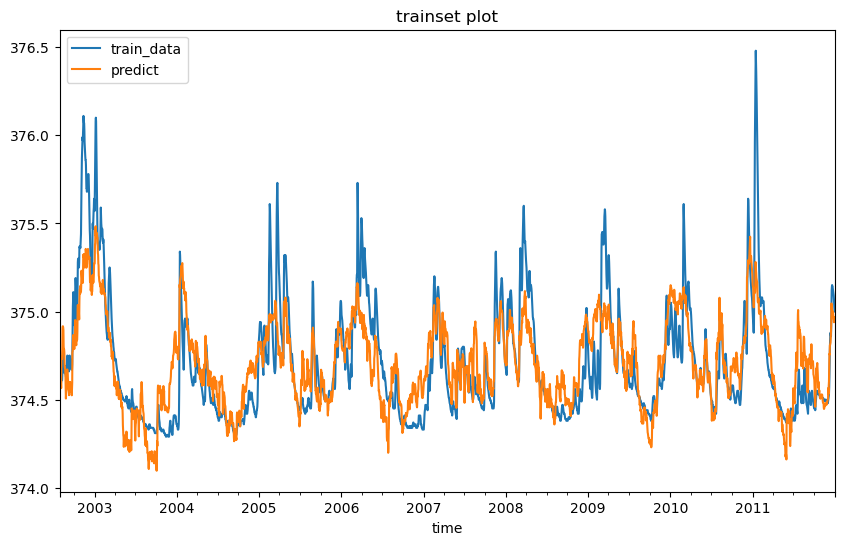

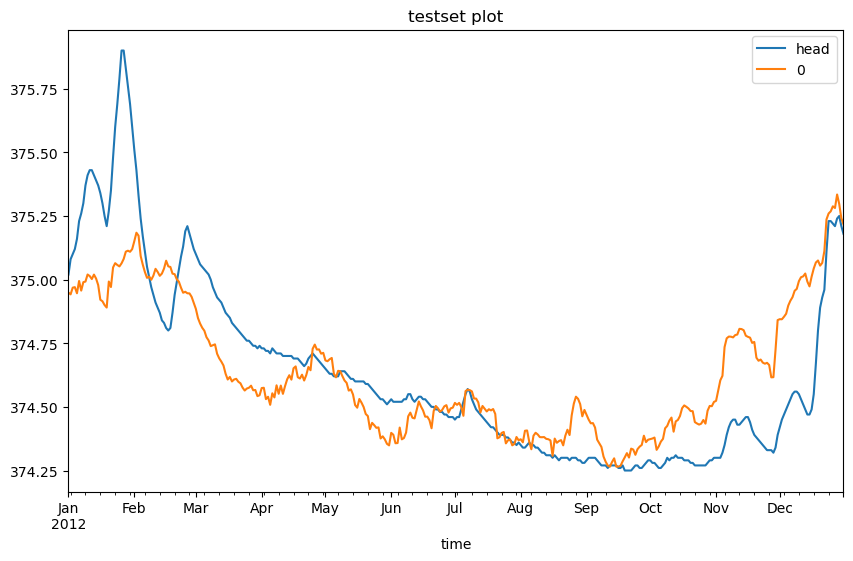

split_year:  2013
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.020570920784377087


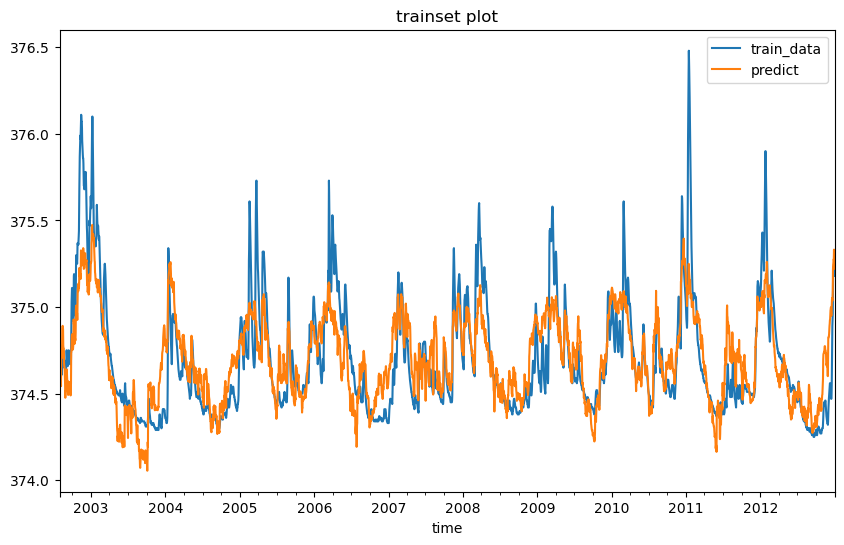

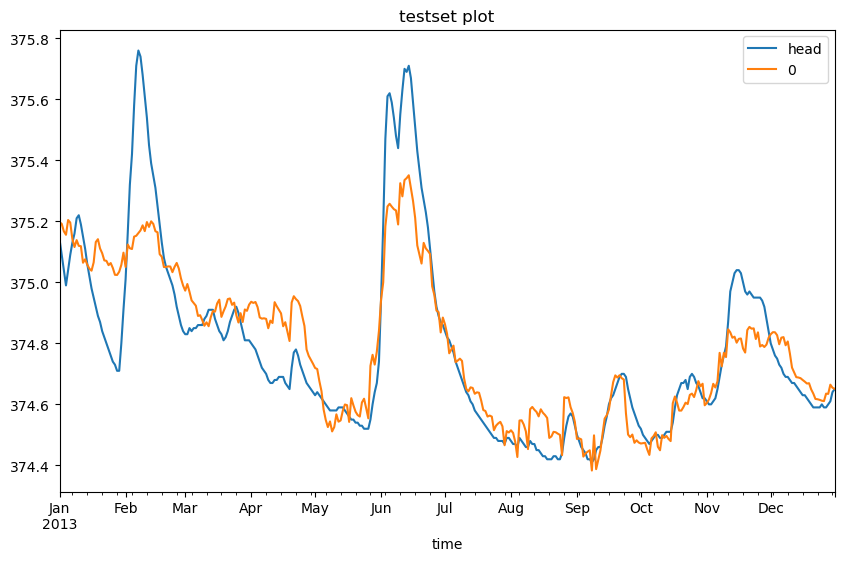

split_year:  2014
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.012041434304669066


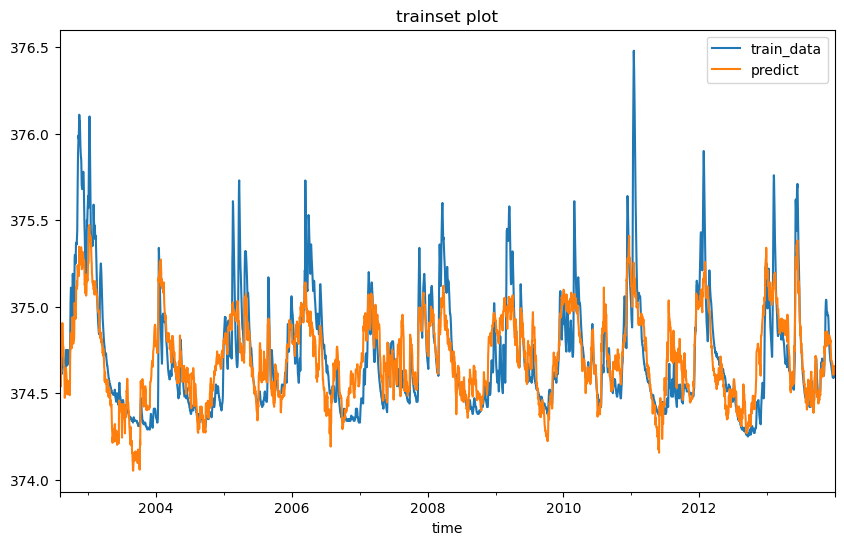

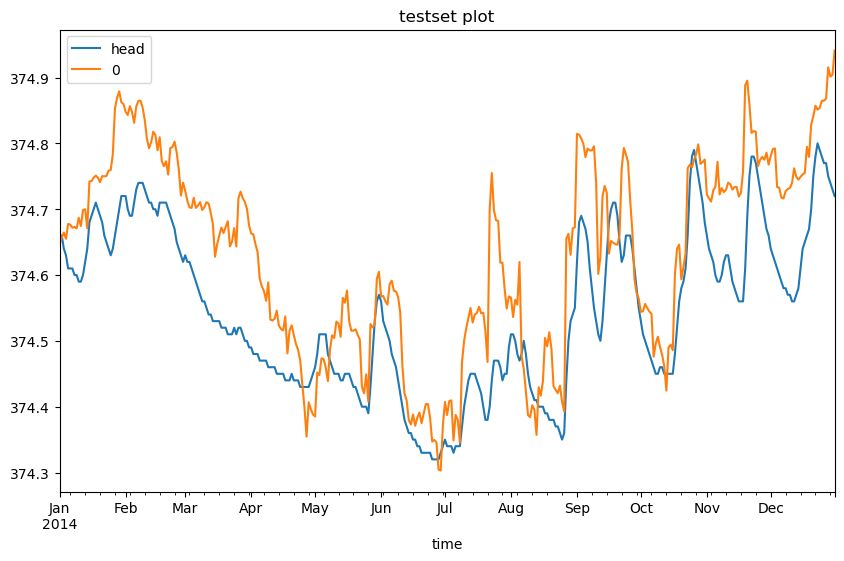

split_year:  2015
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.024843224847488916


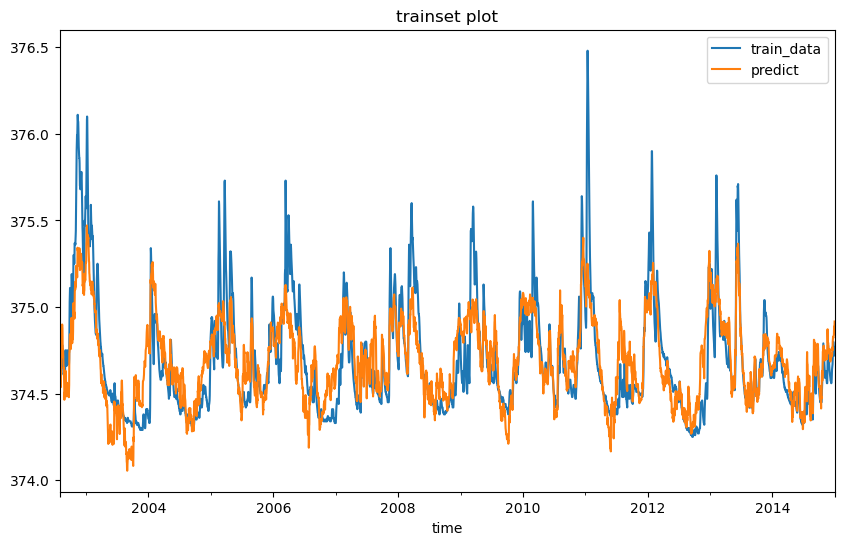

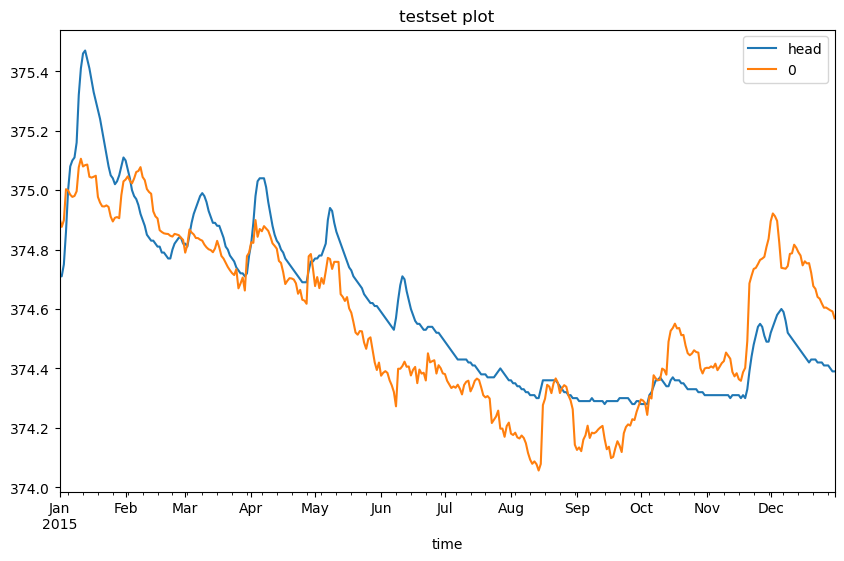

split_year:  2016
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.030872417338254587


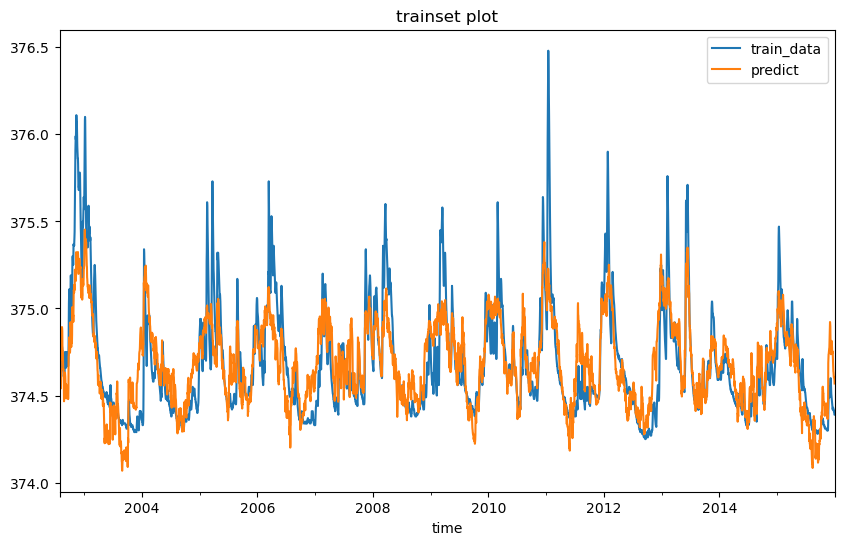

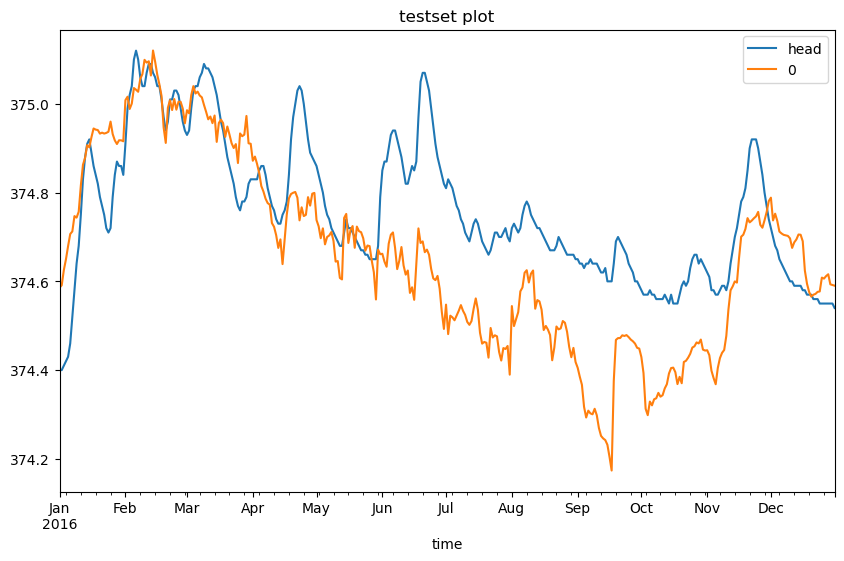

mean of test scores: 0.027741237666409596


In [57]:
# lasso regression
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]

columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), 
                                                   onehot_ftrs),('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=Lasso
parameter_grid = {'lasso__alpha': np.logspace(-2,2,11)} 

lasso_test_scores, lasso_models = MLpipe_Multisplit_KFold_MSE(columnTransformer, ML_algorithm, parameter_grid)

split_year:  2012
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.25}
test score: 0.04533697131434072


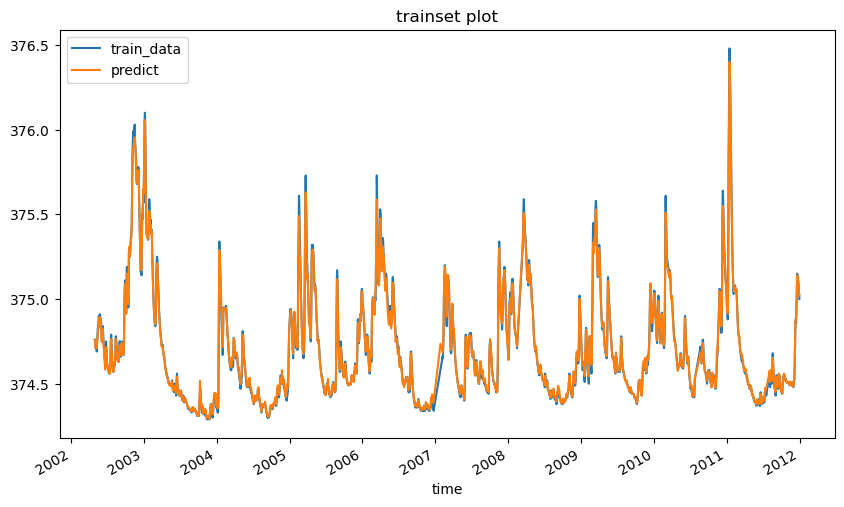

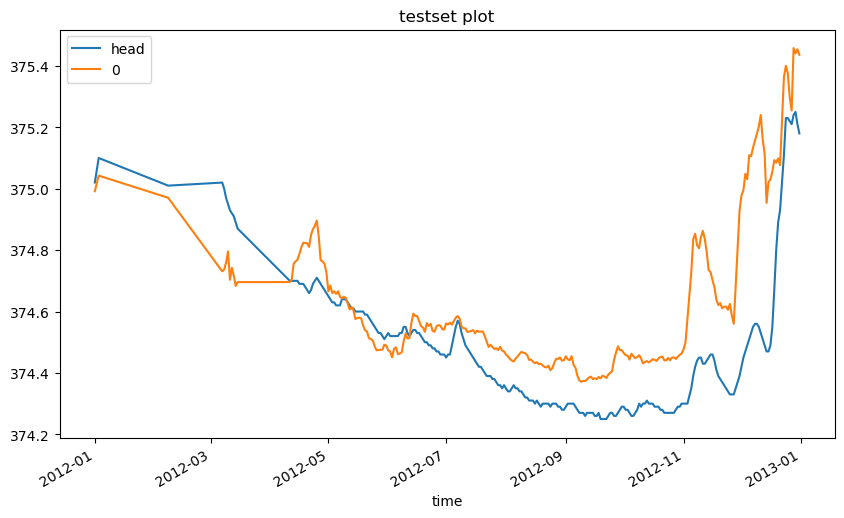

split_year:  2013
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.25}
test score: 0.03844807188281886


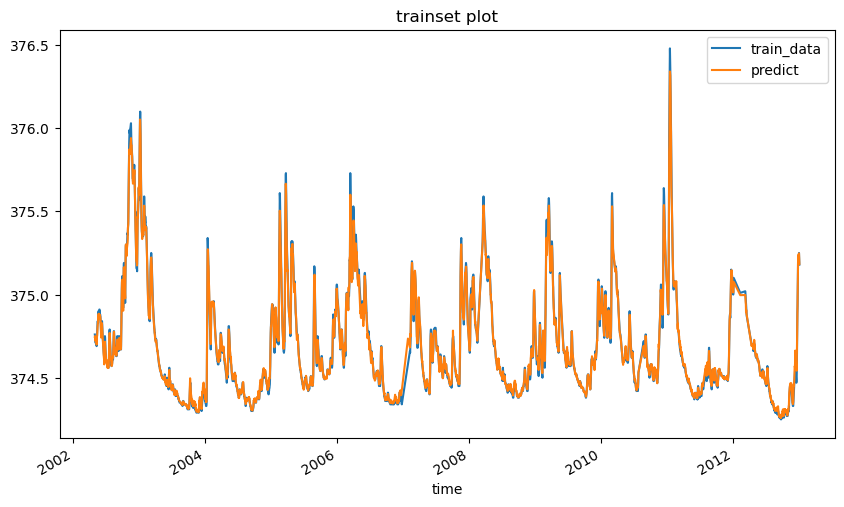

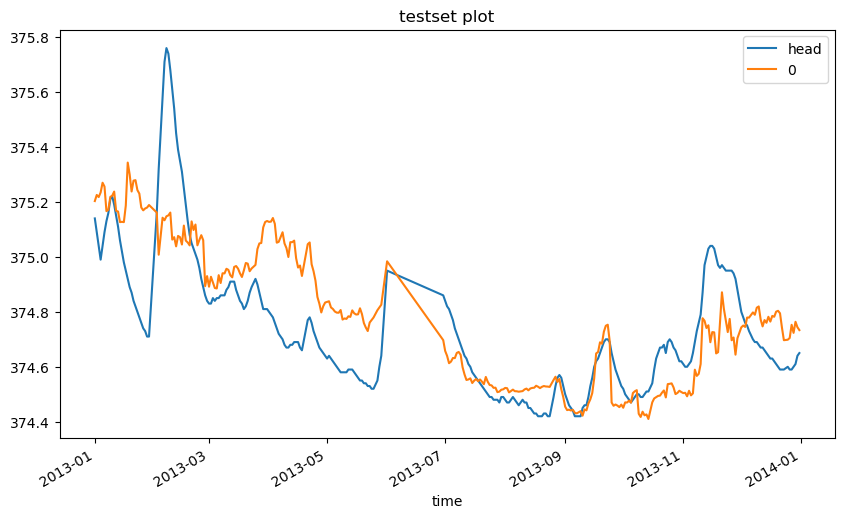

split_year:  2014
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.25}
test score: 0.01983407024647661


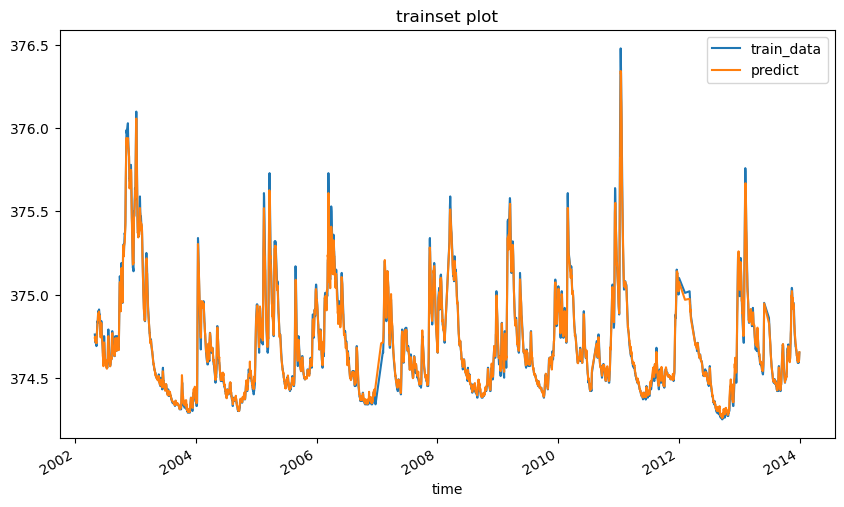

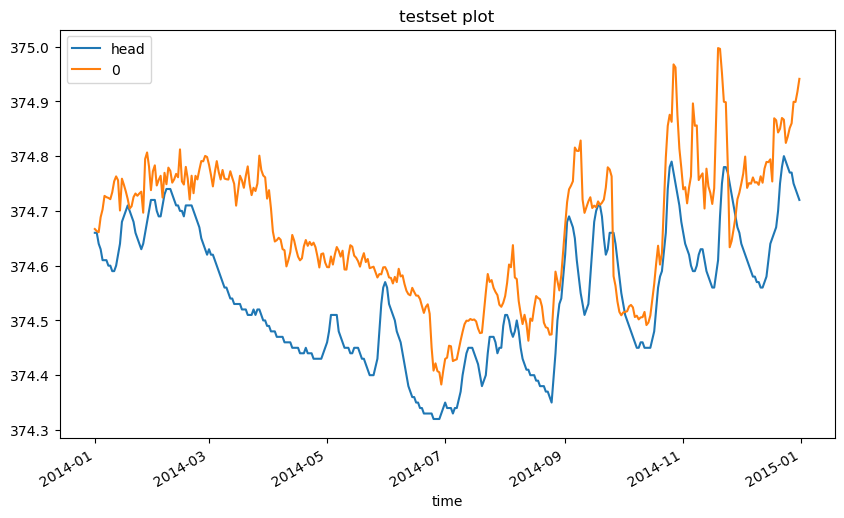

split_year:  2015
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.25}
test score: 0.023452226958887126


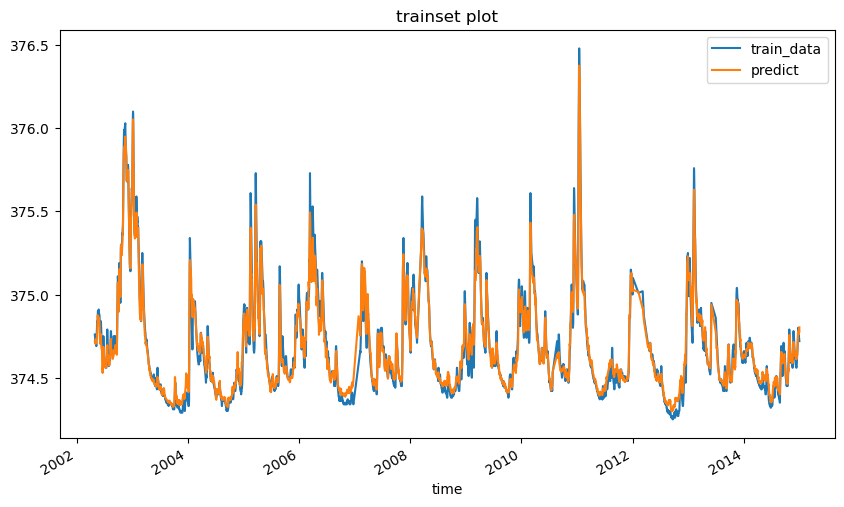

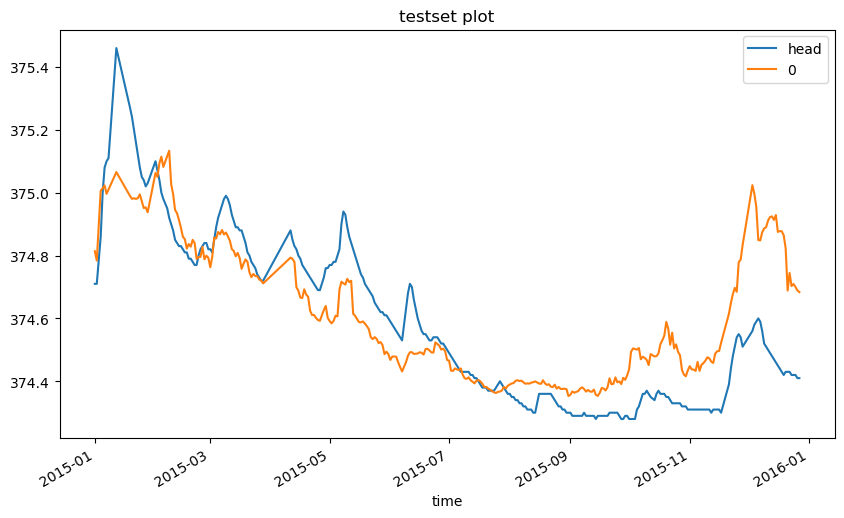

split_year:  2016
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.25}
test score: 0.02846333596189855


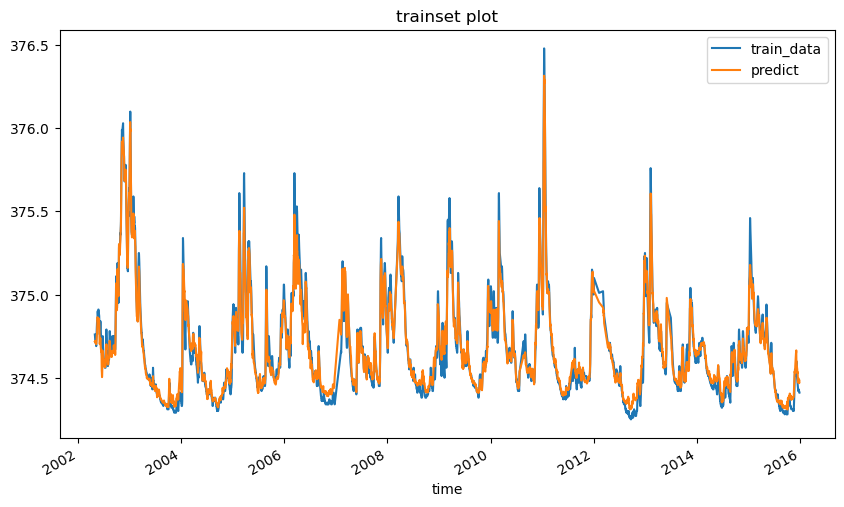

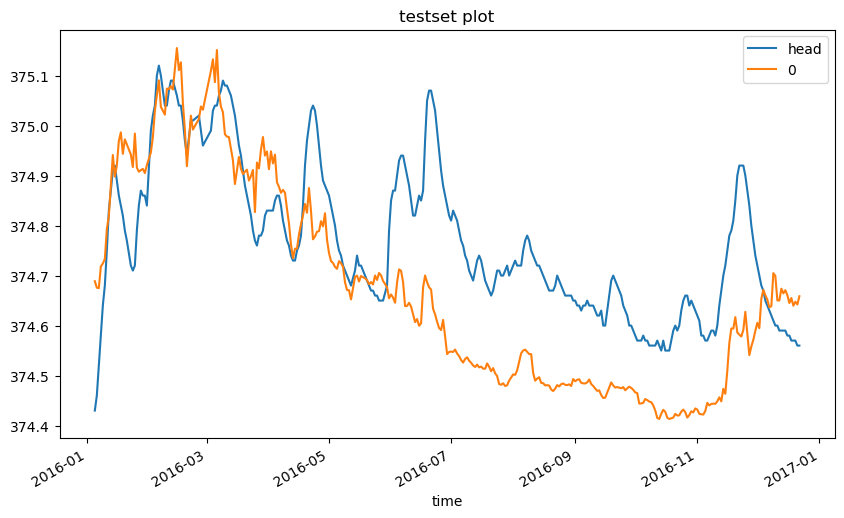

mean of test scores: 0.031106935272884367


In [137]:
# random forest
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                                                  ('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=RandomForestRegressor
parameter_grid = {'randomforestregressor__max_depth': [1,5,10,30,50,100],'randomforestregressor__max_features': [0.01,0.25,0.5,0.75,1]} 

start_time = time.time()
rf_test_scores, rf_models = MLpipe_Multisplit_KFold_MSE(columnTransformer, ML_algorithm, parameter_grid)
end_time = time.time()
rf_runtime = end_time-start_time
print(rf_runtime)

split_year:  2012
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
test score: 0.028611396792258877


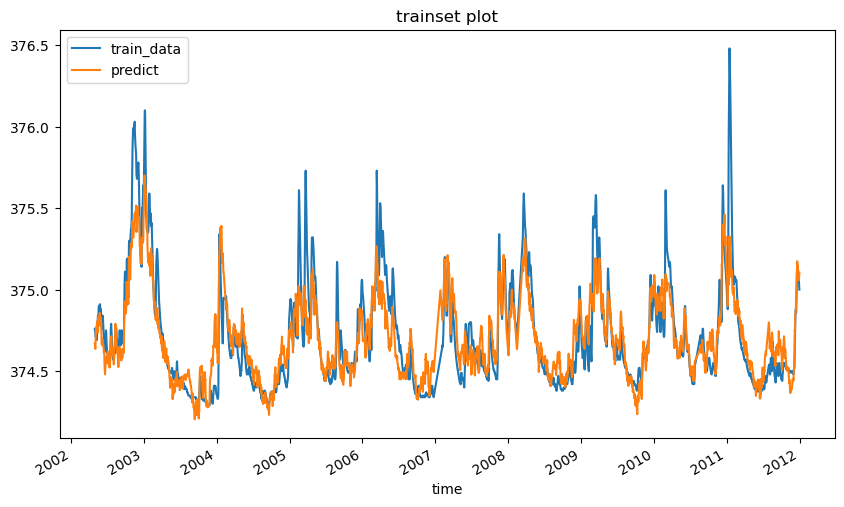

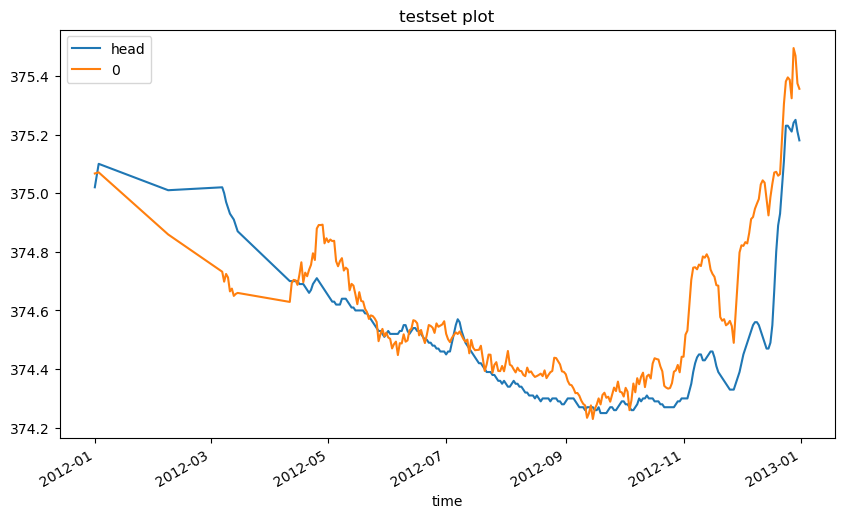

split_year:  2013
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
test score: 0.016929495919473684


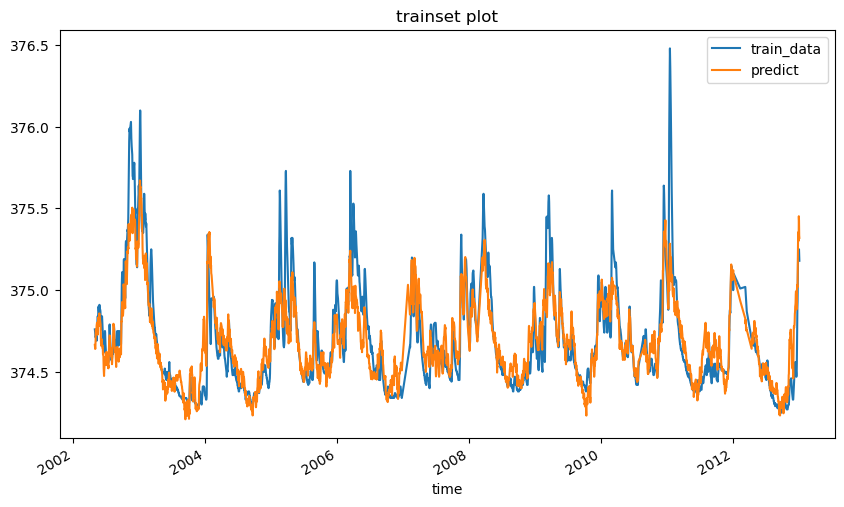

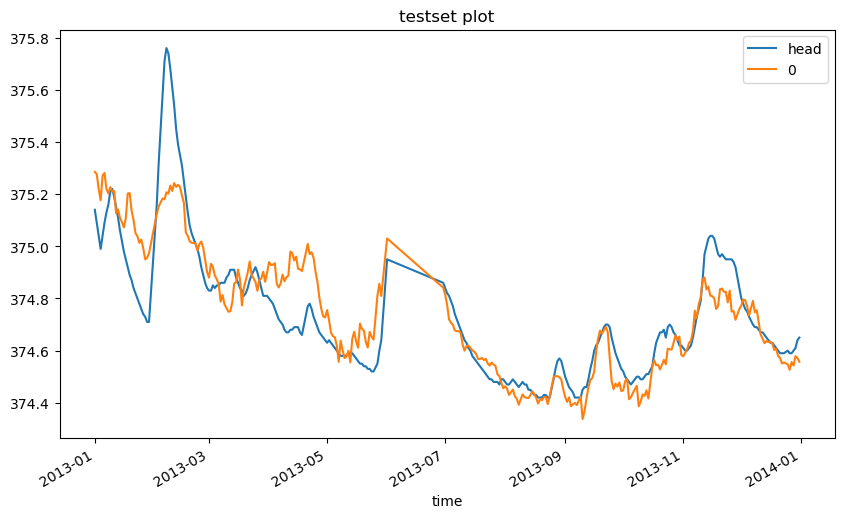

split_year:  2014
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
test score: 0.008770791396718774


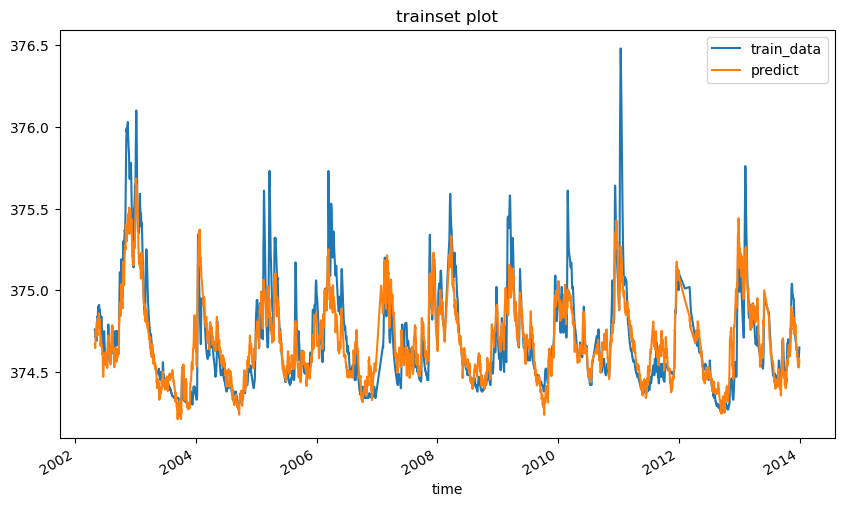

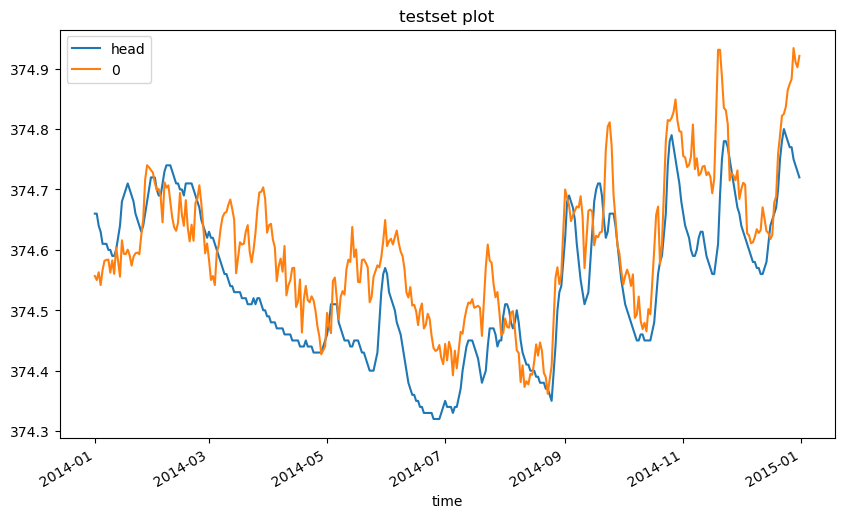

split_year:  2015
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
test score: 0.016501493557269136


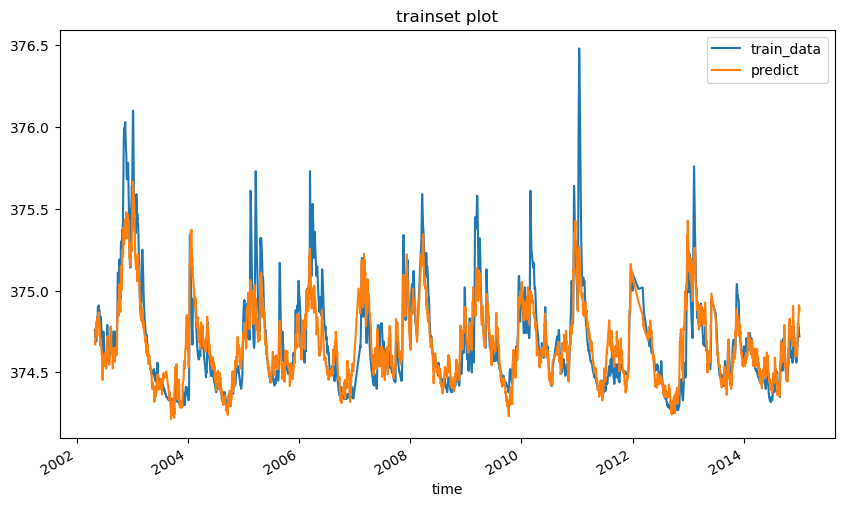

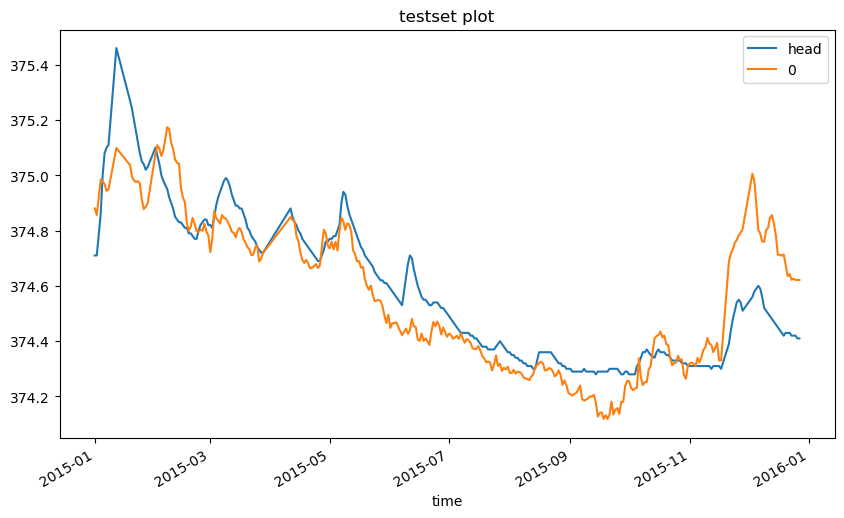

split_year:  2016
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
test score: 0.036516135681794744


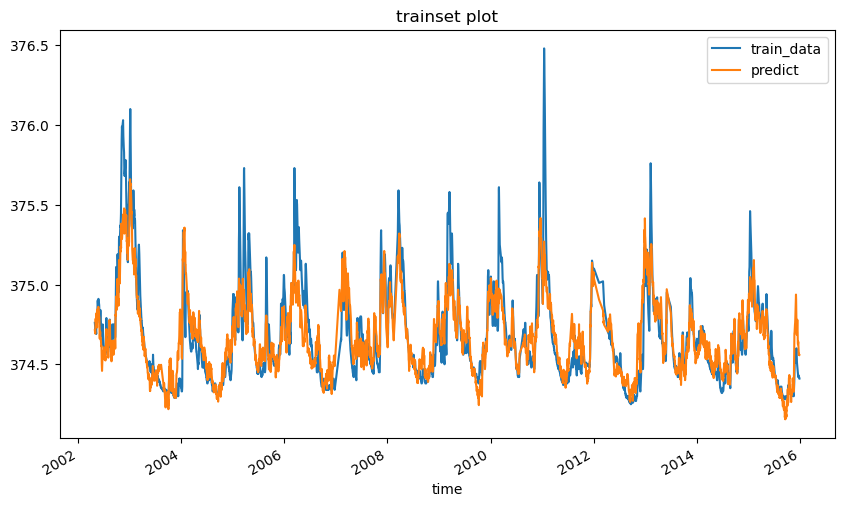

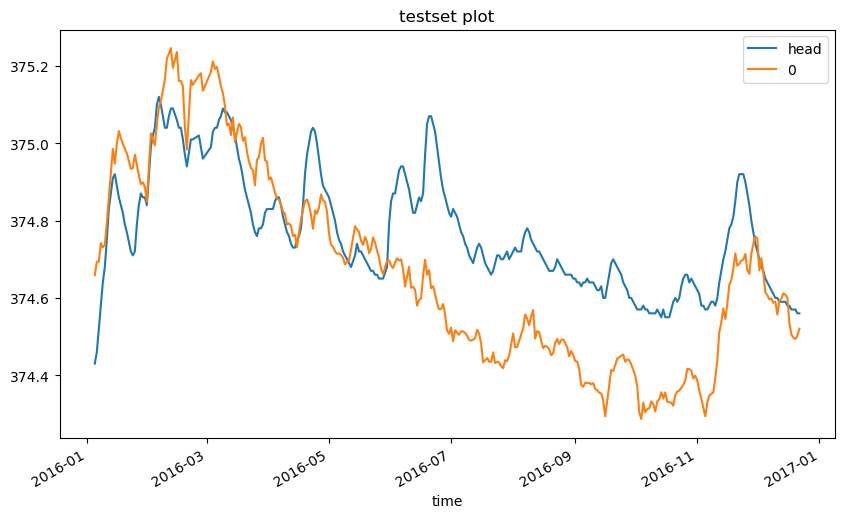

mean of test scores: 0.021465862669503046
167.66128373146057


In [175]:
# SVR
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                                                  ('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=SVR
parameter_grid = {'svr__gamma': [1e-2, 1e-1, 1e1, 1e2, 1e3],'svr__C': [1e-1, 1e0, 1e1]} 

start_time = time.time()
SVR_test_scores, SVR_models = MLpipe_Multisplit_KFold_MSE(columnTransformer, ML_algorithm, parameter_grid)
end_time = time.time()
SVR_runtime = end_time-start_time
print(SVR_runtime)

## Model Results

We chose SVR as our final model because it is the model with the lowest mean RMSE.

In [138]:
lasso_mean = np.mean(lasso_test_scores)
lasso_std = np.std(lasso_test_scores)

SVR_mean = np.mean(SVR_test_scores)
SVR_std = np.std(SVR_test_scores)

rf_mean = np.mean(rf_test_scores)
rf_std = np.std(rf_test_scores)

plt.errorbar(['lasso','SVR','random forest'],[lasso_mean,SVR_mean,rf_mean], yerr=[lasso_std,SVR_std,rf_std],ecolor="hotpink",fmt="o",elinewidth=2,mfc="wheat",capsize=3)
plt.ylabel('MSE score')
plt.show()

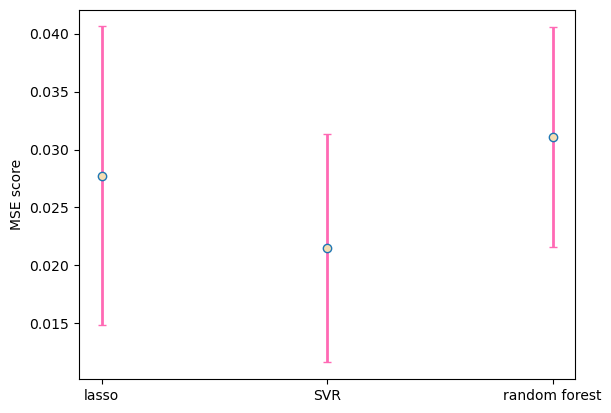

In [176]:
# save the 5 SVR models
import pickle
for i in range(5):
    model = SVR_models[i]
    filename = 'germany_models/SVR_model_{}.sav'.format(i)
    pickle.dump(model, open(filename, 'wb'))



## Predict on submission test data

In [126]:
# prepare and preprocess data for the submission test set
submission_X = df_input[df_input.index>='2002-05-01']
submission_X = create_features(submission_X)
submission_X = submission_X.drop(columns=[col for col in submission_X.columns if (col.startswith('tn') or col.startswith('tx') or col.startswith('et') or col in ['qq_avg_30','tg_avg_90','qq_avg_90'])])

submission_X

/var/folders/3h/rwm3946s6m393kd1m_w94xl00000gn/T/ipykernel_53344/1610939616.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day


,rr,tg,pp,hu,fg,qq,rr_avg_15,rr_avg_30,rr_avg_90,tg_avg_15,...,pp_avg_30,pp_avg_90,hu_avg_15,hu_avg_30,hu_avg_90,fg_avg_15,fg_avg_30,fg_avg_90,qq_avg_15,day
time,,,,,,,,,,,,,,,,,,,,,
2002-05-01,0.000000,12.990000,1008.90000,70.520004,2.88,205.0,1.513333,0.883333,2.123333,9.163333,...,1014.990016,1016.324460,77.525001,72.792001,77.937816,2.276667,2.656333,3.041333,164.400000,1
2002-05-02,0.000000,11.759999,1008.00000,79.690000,2.70,154.0,1.513333,0.883333,2.123333,9.687333,...,1014.696683,1016.194460,77.137335,73.028001,77.821761,2.337333,2.714667,3.047000,167.200000,2
2002-05-03,0.000000,11.880000,1007.70000,89.940000,2.49,102.0,1.513333,0.883333,2.123333,10.092666,...,1014.393348,1015.998904,76.740668,73.592168,77.781705,2.386667,2.718333,3.047556,170.866667,3
2002-05-04,6.300000,8.670000,1009.50000,94.128580,2.40,85.0,1.513333,0.883333,2.123333,10.294666,...,1014.313347,1015.762237,77.909335,74.522668,77.889316,2.482667,2.646667,3.052556,165.866667,4
2002-05-05,7.000000,7.870000,1015.20000,77.665000,1.87,137.0,1.760000,1.093333,2.193333,10.322666,...,1014.396680,1015.615571,78.992573,75.842954,78.061078,2.523333,2.598667,3.064444,160.733333,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.100000,1.300000,1009.50000,94.450005,2.49,27.0,1.080000,1.956667,1.154444,0.686667,...,1016.143340,1019.213344,90.998521,90.379444,88.497865,2.028667,2.433000,2.290889,28.133333,27
2021-12-28,18.300001,3.750000,1004.00000,93.175000,3.34,17.0,1.053333,1.993333,1.166667,0.725333,...,1016.633340,1019.067788,91.307521,90.639111,88.619976,2.050000,2.438000,2.295111,27.666667,28
2021-12-29,6.600000,7.510000,1007.10004,87.680000,4.40,22.0,2.220000,2.523333,1.348889,0.852000,...,1016.833340,1018.905565,91.434076,90.619706,88.768421,2.168667,2.510333,2.302778,27.466667,29


In [127]:
# using final models to create 5 predictions on the submission test set
predictions = []
for i in range(5):
    model = pickle.load(open('germany_models/SVR_model_{}.sav'.format(i), 'rb'))
    prediction = model.predict(submission_X)
    predictions.append(prediction)
predictions = np.array(predictions)

[array([374.67031385, 374.65499137, 374.63928776, ..., 374.87480366,
        374.94816303, 374.99536443]),
 array([374.66522069, 374.65111178, 374.63987333, ..., 374.8468023 ,
        374.91614688, 374.95864651]),
 array([374.6696283 , 374.65848536, 374.64561479, ..., 374.83987919,
        374.90699026, 374.95322141]),
 array([374.68976166, 374.68173521, 374.6698497 , ..., 374.83907443,
        374.89944615, 374.94936366]),
 array([374.71383121, 374.70574069, 374.69427258, ..., 374.83012362,
        374.88901241, 374.93265673])]

In [156]:
# calculate the mean and 95% confidence interval of the prediction
pred_std = np.mean(SVR_test_scores**0.5)
pred_mean = np.mean(predictions,axis=0)
upper = pred_mean + 1.96*pred_std
lower = pred_mean - 1.96*pred_std

In [163]:
submission_form = pd.read_csv('submissions/team_example/submission_form_Germany.csv')

In [164]:
submission_form['Simulated Head'] = pred_mean
submission_form['95% Lower Bound'] = lower
submission_form['95% Upper Bound'] = upper
submission_form

,Date,Simulated Head,95% Lower Bound,95% Upper Bound
0,2002-05-01,374.681751,374.402465,374.961037
1,2002-05-02,374.670413,374.391127,374.949699
2,2002-05-03,374.657780,374.378493,374.937066
3,2002-05-04,374.659947,374.380661,374.939233
4,2002-05-05,374.705187,374.425900,374.984473
...,...,...,...,...
7180,2021-12-27,374.670437,374.391151,374.949724
7181,2021-12-28,374.689365,374.410079,374.968651
7182,2021-12-29,374.846137,374.566850,375.125423
7183,2021-12-30,374.911952,374.632665,375.191238


In [177]:
submission_form.to_csv('submissions/team_example/submission_form_Germany.csv')

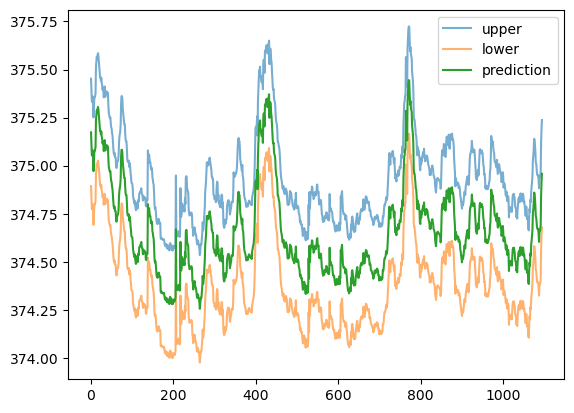

In [172]:

plt.plot(upper[-1095:],alpha=0.6,label='upper')
plt.plot(lower[-1095:],alpha=0.6,label='lower')
plt.plot(pred_mean[-1095:],label='prediction')
plt.legend()
plt.show()